In [1]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import silhouette_score, silhouette_samples
#import matplotlib.ticker as ticker
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
#import matplotlib.cm as cm
import itertools
import networkx as nx
import plotly.figure_factory as ff
from itertools import combinations
from IPython.display import display
from pacmap import PaCMAP

In [2]:
cancer_type = "Brain"

In [3]:
base_path= '/home/pdutta/Data/Cancer_wiseGDC/New_data/{}/Generated_files/Variant_Analysis'.format(cancer_type)
# Subfolders within the base path
subfolders = ['acceptor', 'donor', 'NonTATA', 'TATA']

In [4]:
# Dictionary to hold all dataframes
dataframes = {}

In [5]:
# Load your dataframes here and apply the following transformation
for folder in subfolders:
    current_path = os.path.join(base_path, folder)
    #, 'df_score_change_patientwise.tsv'
    file_names = ['df_log_odd_score_patientwise.tsv']
    for file_name in file_names:
        file_path = os.path.join(current_path, file_name)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, sep='\t')
            #print(df_grouped)
            dataframes[f"{folder}_{file_name.replace('.tsv', '')}"] = df
        else:
            print(f"File not found: {file_path}")

In [6]:
list(dataframes.keys())

['acceptor_df_log_odd_score_patientwise',
 'donor_df_log_odd_score_patientwise',
 'NonTATA_df_log_odd_score_patientwise',
 'TATA_df_log_odd_score_patientwise']

In [7]:
# Assuming dataframes is your dictionary containing grouped dataframes
dataframe_keys = list(dataframes.keys())

# Total number of dataframes
n = len(dataframe_keys)

# To store all combinations
all_combinations = []

# Generate combinations of different lengths
for r in range(1, len(dataframe_keys)+1):
    for combo in combinations(dataframe_keys, r):
        all_combinations.append(combo)

# Now 'all_combinations' contains all the desired combinations of keys
print(all_combinations)

[('acceptor_df_log_odd_score_patientwise',), ('donor_df_log_odd_score_patientwise',), ('NonTATA_df_log_odd_score_patientwise',), ('TATA_df_log_odd_score_patientwise',), ('acceptor_df_log_odd_score_patientwise', 'donor_df_log_odd_score_patientwise'), ('acceptor_df_log_odd_score_patientwise', 'NonTATA_df_log_odd_score_patientwise'), ('acceptor_df_log_odd_score_patientwise', 'TATA_df_log_odd_score_patientwise'), ('donor_df_log_odd_score_patientwise', 'NonTATA_df_log_odd_score_patientwise'), ('donor_df_log_odd_score_patientwise', 'TATA_df_log_odd_score_patientwise'), ('NonTATA_df_log_odd_score_patientwise', 'TATA_df_log_odd_score_patientwise'), ('acceptor_df_log_odd_score_patientwise', 'donor_df_log_odd_score_patientwise', 'NonTATA_df_log_odd_score_patientwise'), ('acceptor_df_log_odd_score_patientwise', 'donor_df_log_odd_score_patientwise', 'TATA_df_log_odd_score_patientwise'), ('acceptor_df_log_odd_score_patientwise', 'NonTATA_df_log_odd_score_patientwise', 'TATA_df_log_odd_score_patient

In [8]:
def data_processing(data):
    # Step 1: Handle missing values
    data_filled = data.fillna(0)
    # Step 2: Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_filled)
    # Step 3: Reduce dimensions using PCA
    pca = PCA(n_components=0.95)  # retain 95% of the variance
    data_reduced = pca.fit_transform(data_scaled)
    #display(data_reduced)
    print("Reduced to %d dimensions" % data_reduced.shape[1])
    return data_reduced

In [9]:
def plotly_silhouette_pacmap1(df, k_max, key):
    data_temp = data_processing(df)  # Assuming a preprocessing function
    
    # Create a subplot figure with 2 columns and as many rows as needed for each k
    fig = make_subplots(rows=k_max-1, cols=2, 
                        subplot_titles=[f'Silhouette Plot for k={k}' for k in range(2, k_max+1)] +
                                        [f'PaCMAP Visualization for k={k}' for k in range(2, k_max+1)],
                        specs=[[{'type': 'xy'}, {'type': 'xy'}] for _ in range(2, k_max+1)])
    
    for k in range(2, k_max+1):
        # KMeans model
        km = KMeans(n_clusters=k, max_iter=300, tol=1e-04, init='k-means++', n_init=10, random_state=42)
        cluster_labels = km.fit_predict(data_temp)
        
        # Silhouette scores
        silhouette_avg = silhouette_score(data_temp, cluster_labels)
        sample_silhouette_values = silhouette_samples(data_temp, cluster_labels)
        
        y_lower = 10  # Initial lower margin for the silhouette plot
        # Generate trace for each cluster in the first column
        for i in range(k):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            fig.add_trace(go.Scatter(
                x=ith_cluster_silhouette_values,
                y=np.arange(y_lower, y_upper),
                mode='lines',
                line=dict(width=0.5),
                fill='tozerox',
                name=f'Cluster {i}'
            ), row=k-1, col=1)
            
            y_lower = y_upper + 10  # Gap between silhouettes
            
        fig.add_trace(go.Scatter(
            x=[silhouette_avg, silhouette_avg],
            y=[0, y_lower],
            mode='lines',
            line=dict(color="red", dash='dash'),
            name='Average'
        ), row=k-1, col=1)
        
        # PaCMAP for visualizing clusters in the second column
        pacmap_instance = PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0)
        embedding = pacmap_instance.fit_transform(data_temp)
        
        cluster_df = pd.DataFrame(embedding, columns=['Component 1', 'Component 2'])
        cluster_df['Cluster'] = cluster_labels
        
        fig.add_trace(go.Scatter(
            x=cluster_df['Component 1'],
            y=cluster_df['Component 2'],
            mode='markers',
            marker=dict(color=cluster_df['Cluster'], size=5, colorscale='Viridis', showscale=False),
            text=cluster_df['Cluster'],
            name='PaCMAP'
        ), row=k-1, col=2)
    
    fig.update_layout(height=600*(k_max-1), width=1200, showlegend=False, title_text="Silhouette and PaCMAP Visualizations for {} dataset".format(key))
    fig.show()

In [23]:
def plotly_silhouette_pacmap(df, k_max, key):
    data_temp = data_processing(df)  # Assuming a preprocessing function
    
    # Create a subplot figure with 2 columns and as many rows as needed for each k
    fig = make_subplots(rows=k_max-1, cols=2, 
                        subplot_titles=[f'Silhouette Plot (k={k})' for k in range(2, k_max+1)] +
                                        [f'PaCMAP Visualization (k={k})' for k in range(2, k_max+1)],
                        specs=[[{'type': 'xy'}, {'type': 'xy'}] for _ in range(2, k_max+1)],
                        vertical_spacing=0.1)
    
    for k in range(2, k_max+1):
        # KMeans model
        km = KMeans(n_clusters=k, max_iter=300, tol=1e-04, init='k-means++', n_init=10, random_state=42)
        cluster_labels = km.fit_predict(data_temp)
        
        # Silhouette scores
        silhouette_avg = silhouette_score(data_temp, cluster_labels)
        sample_silhouette_values = silhouette_samples(data_temp, cluster_labels)
        
        # Update subtitle for silhouette plot with average score
        fig['layout']['annotations'][(k-2)*2]['text'] = f'Silhouette Score: {silhouette_avg:.2f} (k={k})'
        
        y_lower = 10  # Initial lower margin for the silhouette plot
        legend_annotations = []
        
        # Generate trace for each cluster in the first column
        for i in range(k):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            # Add silhouette trace for the ith cluster
            fig.add_trace(go.Scatter(
                x=ith_cluster_silhouette_values,
                y=np.arange(y_lower, y_upper),
                mode='lines',
                line=dict(width=0.5),
                fill='tozerox',
                name=f'Cluster {i}',
                legendgroup=f'group{k}',  # group legends by k value
                showlegend=False
            ), row=k-1, col=1)
            
            y_lower = y_upper + 10  # Gap between silhouettes
            
            # Prepare annotations for a legend-like display
            legend_annotations.append(
                dict(
                    xref=f'x{(k-1)*2}',
                    yref=f'y{(k-1)*2}',
                    x=0.95,
                    y=1 - (0.08 * i),
                    text=f'Cluster {i}: {size_cluster_i} instances',
                    showarrow=False,
                    font=dict(size=10),
                    align='right',
                    xanchor='right',
                    yanchor='top',
                    bgcolor='rgba(255, 255, 255, 0.5)'
                )
            )
            
        # Red dashed line for average silhouette score
        fig.add_trace(go.Scatter(
            x=[silhouette_avg, silhouette_avg],
            y=[0, y_lower],
            mode='lines',
            line=dict(color="red", dash='dash', width=2),
            name=f'Average silhouette score k={k}',
            legendgroup=f'group{k}',
            showlegend=False
        ), row=k-1, col=1)
        
        # PaCMAP for visualizing clusters in the second column
        pacmap_instance = PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0)
        embedding = pacmap_instance.fit_transform(data_temp)
        
        cluster_df = pd.DataFrame(embedding, columns=['Component 1', 'Component 2'])
        cluster_df['Cluster'] = cluster_labels
        
        fig.add_trace(go.Scatter(
            x=cluster_df['Component 1'],
            y=cluster_df['Component 2'],
            mode='markers',
            marker=dict(color=cluster_df['Cluster'], size=5, colorscale='Viridis', showscale=False),
            name=f'PaCMAP k={k}',
            legendgroup=f'group{k}',
            showlegend=False
        ), row=k-1, col=2)
    fig.update_layout(height=600*(k_max-1), width=1200, showlegend=False, title_text="Silhouette and PaCMAP Visualizations for {} dataset".format(key))
    fig.show()

('acceptor_df_log_odd_score_patientwise',)
Reduced to 184 dimensions


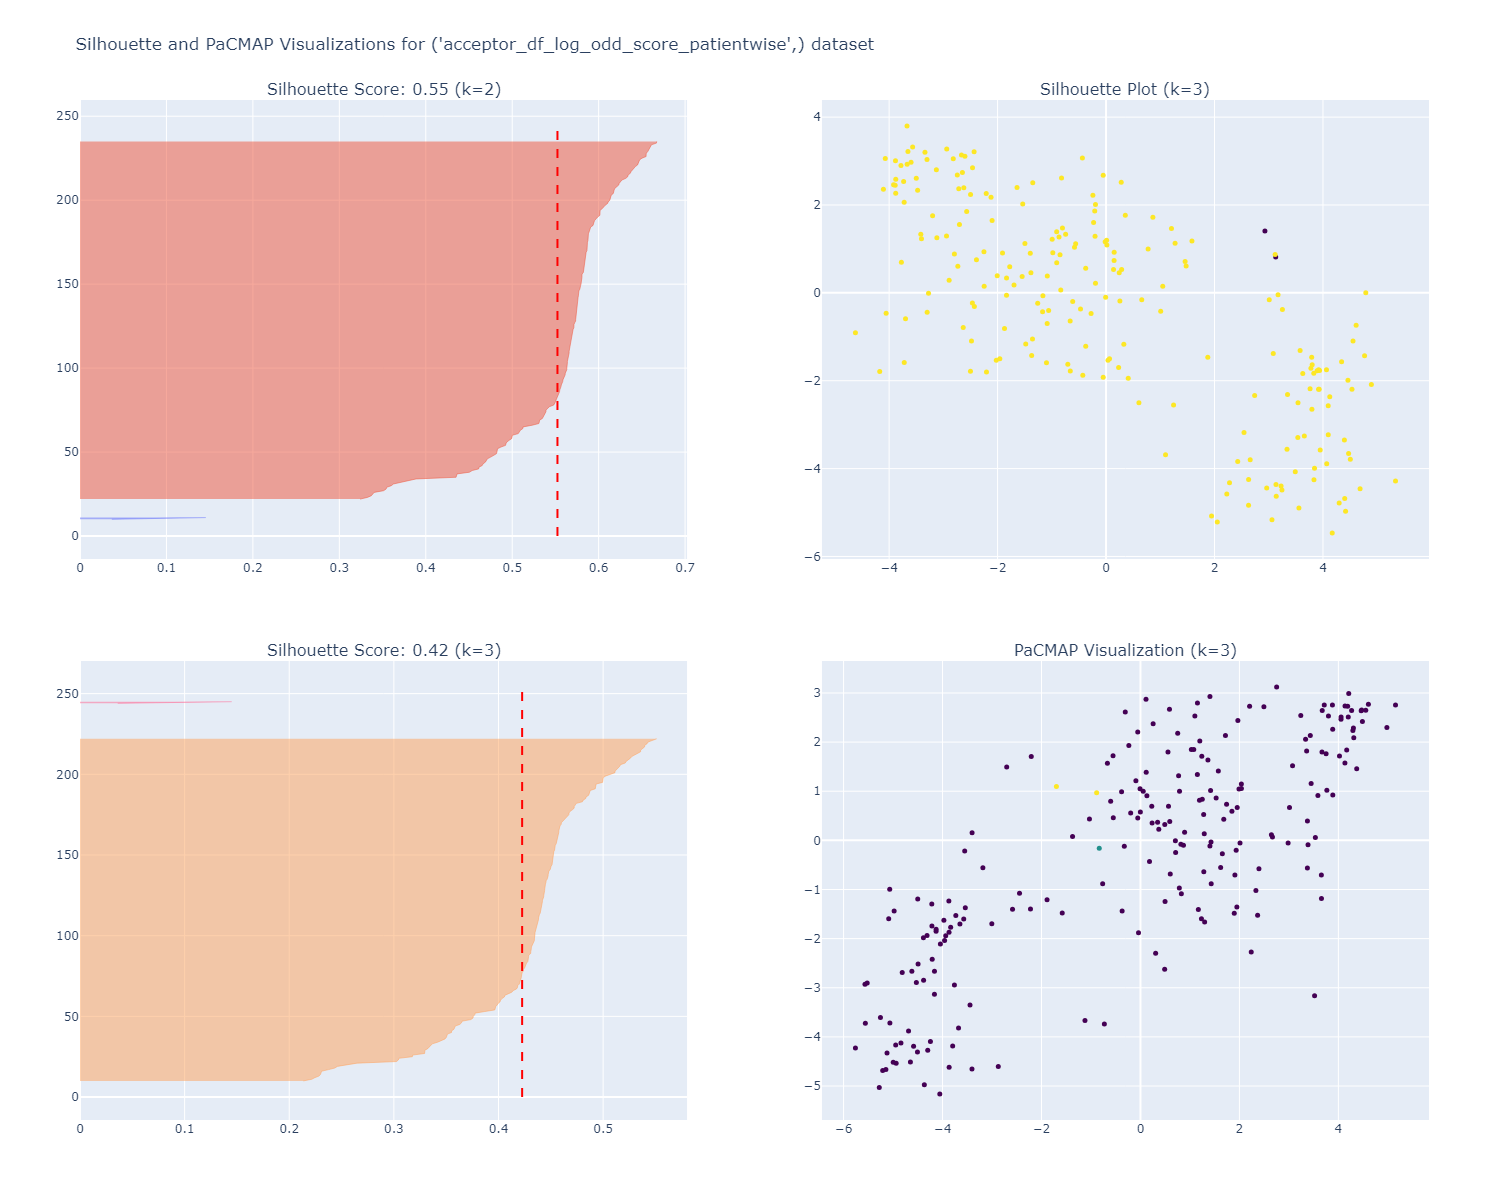

In [ ]:
# Process each combination
combined_dataframes = {}
for combo in all_combinations:
    if len(combo) == 1:
        # Only one dataframe in this combination, directly assign it after setting index
        df = dataframes[combo[0]]
        df = df.set_index('Patient_Core_ID', drop=True)  # Setting index to 'Patient_Core_ID'
        combined_dataframes[combo] = df
    else:
        # Multiple dataframes, merge them on 'Patient_Core_ID'
        merged_df = None
        for key in combo:
            df = dataframes[key]
            df = df.set_index('Patient_Core_ID', drop=True)  # Set 'Patient_Core_ID' as index
            if merged_df is None:
                merged_df = df
            else:
                # Merge maintaining 'Patient_Core_ID' as a single column
                merged_df = pd.merge(merged_df, df, left_index=True, right_index=True, how='inner')
        combined_dataframes[combo] = merged_df
    print(combo)
    plotly_silhouette_pacmap(combined_dataframes[combo], 3, combo)
    input()

In [ ]:
df = dataframes['donor_df_log_odd_score_patientwise']
df

In [ ]:
def calculation(df):
    # Calculate the max value in each column (excluding the first column which we assume is not variant data)
    column_max = df.iloc[:, 1:].max()
    # Sort these max values in descending order
    sorted_max = column_max.sort_values(ascending=False)
    # Extract the column names for the top values
    top_columns = sorted_max.index
    # Count the number of non-NaN values, unique values, and collect all unique values in each of these columns
    non_nan_counts = [df[col].notna().sum() for col in top_columns]
    # Rounding numeric columns to 3 decimal places before finding unique values
    unique_values_list = [np.unique(df[col].dropna().round(3)) for col in top_columns]
    unique_counts = [len(values) for values in unique_values_list]
    # Create a DataFrame from the sorted max values
    top_df = sorted_max.reset_index()
    top_df.columns = ['Column', 'Max Value']
    # Add the non-NaN counts, unique value counts, and list of unique values as new columns
    top_df['Non-NaN Count'] = non_nan_counts
    top_df['Unique Values Count'] = unique_counts
    top_df['Unique Values'] = unique_values_list
    # Drop any rows where the max value is NaN
    top_df = top_df.dropna(subset=['Max Value'])
    # Sort the DataFrame by the 'Non-NaN Count' column in descending order
    top_df = top_df.sort_values(by='Non-NaN Count', ascending=False)
    # Calculate the percentage of non-NaN counts for each column
    top_df['Percentage'] = top_df['Non-NaN Count'] / df.shape[0] * 100
    # Define the bins for percentage ranges
    bins = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100]
    # Bin the percentage values and count how many fall into each bin without adding it to top_df
    binned_counts = pd.cut(top_df['Percentage'], bins=bins).value_counts().sort_index()

    # Return both the binned counts and the enhanced DataFrame top_df
    return binned_counts, top_df

In [ ]:
binned_counts,  df_temp = calculation(dataframes['donor_df_log_odd_score_patientwise'])

In [ ]:
df_temp

In [ ]:
# Assuming your DataFrame 'df' is already sorted by 'Max Value' or you can sort it as required
top_extremes = df_temp.nlargest(40, 'Max Value')
bottom_extremes = df_temp.nsmallest(40, 'Max Value')

# Combine top and bottom for plotting
extreme_values = pd.concat([top_extremes, bottom_extremes])

# Create a scatter plot
fig = px.scatter(extreme_values, x='Column', y='Max Value', size='Non-NaN Count', color='Percentage',
                 hover_data=['Unique Values'], title='Top and Bottom Extreme Values')

fig.update_layout(
    xaxis_title="Variant Column",
    yaxis_title="Max Value",
    xaxis={'categoryorder':'total descending'},
    height=600  # Increased height to better display labels
)

# Rotate the x-axis labels to prevent overlapping
fig.update_xaxes(tickangle=45)  # Rotate labels by 45 degrees

# Show the plot
fig.show()

In [ ]:
# Convert Interval to string for plotting
df_bins = pd.DataFrame({
    'Percentage Range': [str(interval) for interval in binned_counts.index],
    'Count': binned_counts.values
})

# Create a bar chart using Plotly Express
fig = px.bar(df_bins, x='Percentage Range', y='Count', title='Counts of Data Entries Across Percentage Bins')

# Update layout for better readability
fig.update_layout(
    xaxis_title="Percentage Range",
    yaxis_title="Count of Entries",
    xaxis={'categoryorder': 'total descending'},  # Sorts categories based on values, if needed
    height=500  # Adequate height to ensure all labels and titles are visible
)

# Rotate the x-axis labels if needed to prevent overlapping
fig.update_xaxes(tickangle=45)  # Rotate labels by 45 degrees to manage space

# Show the plot
fig.show()

In [ ]:
# Dropping the 'Patient_Core_ID' as it's not relevant for clustering
data = df.drop('Patient_Core_ID', axis=1)
data

In [ ]:
data.fillna(0, inplace=True)

In [ ]:
# Compute the correlation matrix
corr_matrix = data.corr().abs()
corr_matrix

In [ ]:
# Filter the matrix for significant correlations
threshold = 0.95
# Create a boolean mask where correlations are above the threshold
mask = np.abs(corr_matrix) > threshold
# Set diagonal to False to exclude self-correlation
np.fill_diagonal(mask.values, False)

# Apply the mask to the correlation matrix
filtered_corr_matrix = corr_matrix[mask]

# Drop rows and columns that are completely NaN as a result of the masking
filtered_corr_matrix = filtered_corr_matrix.dropna(axis=0, how='all').dropna(axis=1, how='all')
filtered_corr_matrix

In [ ]:
# Create the heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=filtered_corr_matrix.values,
    x=filtered_corr_matrix.columns,
    y=filtered_corr_matrix.index,
    colorscale='Viridis',
    hoverongaps=False))

fig.update_layout(
    title='Interactive Heatmap of Strong Correlations (>0.8)',
    xaxis_title="Features",
    yaxis_title="Features",
    xaxis_nticks=36,
    yaxis_nticks=36
)

fig.show()

In [ ]:
# Filter the matrix for significant correlations
threshold = 0.8  # Adjust the threshold as needed
# Avoid self-loops and only take upper triangle to avoid duplicate edges
edges = np.where(np.triu(corr_matrix > threshold, 1))

In [ ]:
# Create a graph
G = nx.Graph()

# Add edges to the graph based on the thresholded correlation matrix
for i, j in zip(*edges):
    G.add_edge(corr_matrix.columns[i], corr_matrix.columns[j], weight=corr_matrix.iloc[i, j])

# Position nodes using the spring layout
pos = nx.spring_layout(G, seed=42)

# Extract positions for plotting
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

node_x = [pos[node][0] for node in G.nodes()]
node_y = [pos[node][1] for node in G.nodes()]

# Create traces for Plotly
edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='#888'), hoverinfo='none', mode='lines')
node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text',
                        marker=dict(showscale=True, colorscale='YlGnBu', size=10,
                                    color=list(dict(G.degree()).values()),
                                    colorbar=dict(thickness=15, title='Node Connections', xanchor='left', titleside='right'),
                                    line_width=2))

In [ ]:
# Add hover text (node labels) to the nodes
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append(f'{adjacencies[0]} (# of connections: {len(adjacencies[1])})')

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

# Create the figure for plotting
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(title='<br>Network graph of feature correlations', titlefont_size=16,
                                 showlegend=False, hovermode='closest',
                                 margin=dict(b=20,l=5,r=5,t=40),
                                 annotations=[dict(text="Python code by OpenAI's Assistant",
                                                   showarrow=False, xref="paper", yref="paper", x=0.005, y=-0.002)],
                                 xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                 yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

fig.show()

In [ ]:
def silhouette_plot(X, model, ax, colors):
    y_lower = 10
    y_tick_pos_ = []
    sh_samples = silhouette_samples(X, model.labels_)
    sh_score = silhouette_score(X, model.labels_)
    
    for idx in range(model.n_clusters):
        values = sh_samples[model.labels_ == idx]
        values.sort()
        size = values.shape[0]
        y_upper = y_lower + size
        ax.fill_betweenx(np.arange(y_lower, y_upper),0,values,
                         facecolor=colors[idx],edgecolor=colors[idx]
        )
        y_tick_pos_.append(y_lower + 0.5 * size)
        y_lower = y_upper + 10

    ax.axvline(x=sh_score, color="red", linestyle="--", label="Avg Silhouette Score")
    ax.set_title("Silhouette Plot for {} clusters".format(model.n_clusters))
    l_xlim = max(-1, min(-0.1, round(min(sh_samples) - 0.1, 1)))
    u_xlim = min(1, round(max(sh_samples) + 0.1, 1))
    ax.set_xlim([l_xlim, u_xlim])
    ax.set_ylim([0, X.shape[0] + (model.n_clusters + 1) * 10])
    ax.set_xlabel("silhouette coefficient values")
    ax.set_ylabel("cluster label")
    ax.set_yticks(y_tick_pos_)
    ax.set_yticklabels(str(idx) for idx in range(model.n_clusters))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.legend(loc="best")
    return ax

In [ ]:
def silhouette_plot1(X, clusterer, ax, colors):
    # Calculate silhouette scores
    cluster_labels = clusterer.labels_
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10  # Starting y position for the plot
    for i in range(clusterer.n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors[i % len(colors)]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples gap between clusters

    ax.set_title("Silhouette plot for k = %d" % clusterer.n_clusters)
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [ ]:
cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']

In [ ]:
# Step 1: Handle missing values
data_filled = data.fillna(0)
data_filled

In [ ]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_filled)
data_scaled

In [ ]:
# Step 3: Dimensionality Reduction with PCA
pca = PCA(n_components=0.95)  # retain 95% of the variance
data_reduced = pca.fit_transform(data_scaled)
print("Reduced to %d dimensions" % data_reduced.shape[1])

In [ ]:
# Get the loadings of the original features on the principal components
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])], index=data.columns)

# Show the top contributing features for each principal component
top_features = {component: loadings[component].nlargest(3).index.tolist() for component in loadings.columns}

# Get a union of all unique features across all components
unique_features = set()
for features in top_features.values():
    unique_features.update(features)

print("Unique top contributing features across all principal components:")
print(unique_features)

# Calculate the absolute cumulative importance score for each feature across all components
# The cumulative importance is the sum of the absolute values of the loadings for each feature
feature_importance = loadings.abs().sum(axis=1).sort_values(ascending=False)

# Display the features sorted by their cumulative importance
print("Features sorted by their importance:")
print(feature_importance)

In [ ]:
# Set up the figure
k_max = 6
ncols = 3
nrows = k_max // ncols + (k_max % ncols > 0)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 4), dpi=200)

# Generate silhouette plots for different k values
for k in range(2, k_max+1):
    ax = axes.flatten()[k-2]  # Get the subplot for the current k
    km = KMeans(n_clusters=k, max_iter=300, tol=1e-04, init='k-means++', n_init=10, random_state=42)
    km_fit = km.fit(data_reduced)
    
    # Colors for the clusters
    cluster_colors = cm.viridis(np.linspace(0, 1, k))
    silhouette_plot1(data_reduced, km_fit, ax, cluster_colors)

fig.suptitle("Silhouette Plots for Various k", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Settings for Plotly
k_max = 6
plots = []

# Perform clustering and silhouette analysis for a range of k values
for k in range(2, k_max+1):
    kmeans =  KMeans(n_clusters=k, max_iter=300, tol=1e-04, init='k-means++', n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(data_reduced)

    # Silhouette score for each sample
    silhouette_vals = silhouette_samples(data_reduced, cluster_labels)

    # Average silhouette score
    silhouette_avg = silhouette_score(data_reduced, cluster_labels)

    # Create traces for each cluster's silhouette scores
    y_upper = 0
    traces = []
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = silhouette_vals[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_lower = y_upper
        y_upper = y_lower + size_cluster_i

        # Colors can be made dynamic, here using Viridis
        color = px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)]
        
        # Create a trace for the plot
        trace = go.Bar(
            x=ith_cluster_silhouette_values,
            y=list(range(y_lower, y_upper)),
            orientation='h',
            marker=dict(color=color),
            name=f"Cluster {i}",
            showlegend=True
        )
        traces.append(trace)
    
    # Layout for each subplot
    layout = go.Layout(
        title=f"Silhouette Analysis for k={k} (avg score: {silhouette_avg:.3f})",
        xaxis=dict(title="Silhouette Coefficient"),
        yaxis=dict(title="Sample Index"),
        height=300,
        margin=dict(l=20, r=20, t=40, b=20)
    )

    # Fig for each k
    fig = go.Figure(data=traces, layout=layout)
    plots.append(fig)

# Display all plots
for fig in plots:
    fig.show()